# CLV and CLV Prediction

**Reference:** *https://www.kaggle.com/code/mehmeteryilmazz/clv-and-clv-prediction*

### Importing Required Libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import pandas as pd
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


### 1. Connecting to DB

In [2]:
# Establish a connection to your SQLite database
conn = sqlite3.connect('data.db')

### 2. Deriving Data

In [3]:
query = '''
SELECT
    s.sales_id,
    d.date,
    s.customer_id,
    s.transaction_id,
    p.product_category,
    p.SKU,
    s.quantity,
    p.price as unit_price
FROM
    date d 
JOIN
    sales_fact s ON d.date_id = s.date_id
JOIN
    product p ON s.product_id = p.product_id;
'''

In [4]:
# Read query results into a pandas DataFrame
df = pd.read_sql_query(query, conn)
df

sales_id        date  customer_id  transaction_id product_category    SKU  quantity  unit_price
0             1  2021-06-05         1098               0         Clothing  4C555         4    44.96000
1             2  2021-06-05         1098               0           Beauty  25F7D        10    90.25000
2             3  2021-06-05         1098               0       Industrial  805A9        13    62.01000
3             4  2021-06-05         1098               0       Automotive  E5CE6        12     1.26000
4             5  2019-12-24          592               1      Electronics  6C804        11    48.97000
5             6  2019-12-24          592               1      Electronics  90326        13    54.32000
6             7  2002-09-27          580               2           Movies  7DFBF        19    57.76000
7             8  2002-09-27          580               2          Grocery  4ABD3        17     5.65000
8             9  2002-09-27          580               2          Grocery  D7F73         3    26.83000
9            10  2002-09-27          580               2         Outdoors  6BA14         3    45.40000
10           11  2002-09-27          580               2            Books  E49FF        11    39.46000
11           12  2011-01-29          372               3            Music  0B1DA         2    30.88000
12           13  2011-01-29          372               3            Books  299FD         7    69.17000
13           14  2011-01-29          372               3             Kids  E4110         3    99.10000
14           15  2005-07-24         1695               4           Health  E2233        12    78.29000
15           16  2005-07-24         1695               4           Movies  ADBD5        16    90.04000
16           17  2005-07-24         1695               4       Industrial  E6FEE        17    40.81000
17           18  2005-07-24         1695               4           Sports  B7ECE        11    22.23000
18           19  2022-04-09          455               5            Music  EE289        13    39.80000
19           20  2022-04-09          455               5         Jewelery  871E2         1    29.04000
20           21  2010-10-19          204               6            Shoes  92BB1         1    69.49000
21           22  2010-10-19          204               6            Shoes  EE25F        18    28.65000
22           23  2010-10-19          204               6       Industrial  23E9E         4    77.72000
23           24  2014-11-30          278               7             Kids  08865        12    15.46000
24           25  2014-11-30          278               7           Garden  13B45         4    48.42000
25           26  2019-05-24         2074               8             Baby  FC340         7    71.28000
26           27  2019-05-24         2074               8         Jewelery  655D7         9    39.42000
27           28  2005-12-30          276               9       Industrial  37D4E         3    97.69000
28           29  2005-12-30          276               9           Beauty  E3E89        12    99.56000
29           30  2005-12-30          276               9             Kids  D0A84        19    70.73000
30           31  2005-12-30          276               9          Grocery  E1CC3        19    13.73000
31           32  2014-04-11         1595              10            Music  F2E07         1    16.64000
32           33  2020-01-26         2938              11       Industrial  5A409        10    34.03000
33           34  2020-01-26         2938              11           Beauty  E3BDD         9    37.27000
34           35  2020-01-26         2938              11            Shoes  C4DF0        16    27.98000
35           36  2020-01-26         2938              11         Outdoors  E89DD        18     2.66000
36           37  2020-01-26         2938              11          Grocery  3DCB2        19    75.82000
37           38  2013-09-25          406              12             Baby  C45E5        18   

In [5]:
# Trying to understand the data.

def check_df(dataframe, head=7):
    print("################### Shape ####################")
    print(dataframe.shape)
    print("#################### Info #####################")
    print(dataframe.info())
    print("################### Nunique ###################")
    print(dataframe.nunique())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("################## Quantiles #################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("#################### Head ####################")
    print(dataframe.head(head))

check_df(df)

################### Shape ####################
(12065, 8)
#################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12065 entries, 0 to 12064
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sales_id          12065 non-null  int64  
 1   date              12065 non-null  object 
 2   customer_id       12065 non-null  int64  
 3   transaction_id    12065 non-null  int64  
 4   product_category  12065 non-null  object 
 5   SKU               12065 non-null  object 
 6   quantity          12065 non-null  int64  
 7   unit_price        12065 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 754.2+ KB
None
################### Nunique ###################
sales_id            12065
date                 3206
customer_id          2186
transaction_id       4000
product_category       22
SKU                  4582
quantity               19
unit_price       

### **What is Customer Lifetime Value(CLV)?**

***The monetary value a customer will bring to a company during their relationship and communication is known as "customer lifetime value."***

This will be achieved by using the formulas below:

* **Repeat rate:** number of customers who make multiple purchases / all customers

* **Churn rate:** 1 - repeat rate

* **Purchase frequency:** total transactions / total number of unique customers

* **Average order value:** total price / total transactions

* **Customer value:** average order value * purchase frequency

* **Profit margin:** total price * profit margin rate(provided by the company)

* **CLV** = (customer value / churn rate) * profit margin

*Customers are segmented based on the generated CLV value, and operations are carried out according to these segments.*

#### **Dataset Details**

* **sale_id**: Unique Sale ID Number for each Respective Sale

* **date**: Date of Sales Transaction

* **customer_id**: Unique Customer iID for each Customer

* **transaction_id**: ID of the Transaction

* **product_category**: Product Category Name

* **SKU**: Product Code

* **quantity**: Number of Items Sold in the Transaction

* **unit_price** : Unit Price of the Respective Product

In [6]:
# finding the total sale amount for each transaction.
df["sales_amount"] = df["unit_price"] * df["quantity"]

# accessing the values required for the formulas.
cltv = df.groupby('customer_id').agg({'transaction_id': lambda x: x.nunique(),  # total transaction
                                        'sales_amount': lambda x: x.sum()})     # total price

# changing the names of the variables we have created.
cltv.columns = ['total_transaction', 'total_price']

cltv.head()

total_transaction  total_price
customer_id                                
0                            2   2709.35000
1                            1   3405.42000
2                            1   1679.49000
3                            2   3427.36000
4                            4  10040.15000

In [7]:
# Average Order Value (average_order_value = total_price / total_transaction)
cltv["average_order_value"] = cltv["total_price"] / cltv["total_transaction"]

# Purchase Frequency (total_transaction / total_number_of_customers)
cltv.shape[0]  # total number of customers
cltv["purchase_frequency"] = cltv["total_transaction"] / cltv.shape[0]

# Repeat Rate & Churn Rate
# (number of customers who make multiple purchases / all customers)
repeat_rate = cltv[cltv["total_transaction"] > 1].shape[0] / cltv.shape[0]
churn_rate = 1 - repeat_rate

# Profit Margin (total price * profit margin rate)
# Setting the profit margin rate as 0.10.
cltv['profit_margin'] = cltv['total_price'] * 0.10

# Customer Value (customer_value = average_order_value * purchase_frequency)
cltv['customer_value'] = cltv['average_order_value'] * cltv["purchase_frequency"]

# Customer Lifetime Value (CLV = (customer_value / churn_rate) x profit_margin)
cltv["cltv"] = (cltv["customer_value"] / churn_rate) * cltv["profit_margin"]

cltv.head()

total_transaction  total_price  average_order_value  purchase_frequency  profit_margin  customer_value       cltv
customer_id                                                                                                                   
0                            2   2709.35000           1354.67500             0.00091      270.93500         1.23941  716.85326
1                            1   3405.42000           3405.42000             0.00046      340.54200         1.55783 1132.50834
2                            1   1679.49000           1679.49000             0.00046      167.94900         0.76829  275.45768
3                            2   3427.36000           1713.68000             0.00091      342.73600         1.56787 1147.14810
4                            4  10040.15000           2510.03750             0.00183     1004.01500         4.59293 9844.20039

In [8]:
# Creating the Segments

# Dividing the CLTV values into 4 parts and creating a segment variable.
cltv["segment"] = pd.qcut(cltv["cltv"], 4, labels=["D", "C", "B", "A"])

cltv.sort_values(by="cltv", ascending=False).head()

total_transaction  total_price  average_order_value  purchase_frequency  profit_margin  customer_value        cltv segment
customer_id                                                                                                                            
36                           5  13330.71000           2666.14200             0.00229     1333.07100         6.09822 17354.28019       A
1366                         7  13066.54000           1866.64857             0.00320     1306.65400         5.97737 16673.28785       A
1963                         5  13005.09000           2601.01800             0.00229     1300.50900         5.94926 16516.83261       A
1184                         5  12743.08000           2548.61600             0.00229     1274.30800         5.82941 15858.01640       A
1247                         5  12728.07000           2545.61400             0.00229     1272.80700         5.82254 15820.68027       A

In [9]:
# Creating count, mean, and sum values for all other variables based on the segments.
cltv.groupby("segment").agg({"count", "mean", "sum"})

# Thus, we can perform operations on customers based on their segments.

total_transaction             total_price                     average_order_value                     purchase_frequency               profit_margin                    customer_value                        cltv                    
                     mean   sum count        mean           sum count                mean           sum count               mean     sum count          mean          sum count           mean        sum count       mean           sum count
segment                                                                                                                                                                                                                                       
D                 1.14077   624   547   680.13530  372034.01000   547           623.42974  341016.06833   547            0.00052 0.28545   547      68.01353  37203.40100   547        0.31113  170.18939   547   57.45610   31428.48522   547
C                 1.40110   765   546  1792.84018  978890.74000   546          1454.84545  794345.61500   546            0.00064 0.34995   546     179.28402  97889.07400   546        0.82015  447.79997   546  323.70283  176741.74446   546
B                 1.91758  1047   546  3118.80278 1702866.32000   546          1902.86152 1038962.39167   546            0.00088 0.47896   546     311.88028 170286.63200   546        1.42672  778.98734   546  969.54047  529369.09671   546
A                 2.85923  1564   547  5647.92995 3089417.68000   547          2137.33645 1169123.04074   547            0.00131 0.71546   547     564.79299 308941.76800   547        2.58368 1413.27433   547 3385.18484 1851696.10621   547

### **CLV Prediction with BG-NBD and Gamma-Gamma**

***CLTV Prediction: BG/NBD Gamma gamma submodel***

Hereby, performing CLTV prediction with BG/NBD and Gamma-Gamma.

#### Expected Number of Transactions with BG/NBD.

BG/NBD is used as a standalone sales prediction model, that is; it predicts the expected number of purchases per customer.

**The information we need to use in this model and learn from the customer is:**

* **frequency:** Number of repeated purchases by the customer (more than 1) (frequency)

* **recency:** Time between a customer's first and last purchase

* **T:** Time since the customer's first purchase (customer's age)

In [10]:
# Data Preparation

# Converting the date in object format to datetime format using the datetime module.
df["date"] = pd.to_datetime(df["date"])

In [11]:
# Find the last date and make transactions starting from 2 days later.
df["date"].max()  # '2023-12-29'
today_date = pd.to_datetime("2023-12-31")

In [12]:
# Calculating the necessary values for our calculations.
cltv_pr = df.groupby('customer_id').agg(
    {'date': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,  # tx: recency degeri
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],         # T: customer's age
     'transaction_id': lambda Invoice: Invoice.nunique(),    # x: frequency degeri
     'sales_amount': lambda TotalPrice: TotalPrice.sum()})

# The variables in the output are displayed in two rows. Need to remove the first row.
cltv_pr.columns = cltv_pr.columns.droplevel(0)

# Changing the names of the variables we have created.
cltv_pr.columns = ['recency', 'T', 'frequency', 'monetary']

# mx: monetary degeri. total price/frequency
cltv_pr["monetary"] = cltv_pr["monetary"] / cltv_pr["frequency"]

# The frequency refers to customers who made more than one purchase.
cltv_pr = cltv_pr[(cltv_pr['frequency'] > 1)]

# Converting the recency value into weekly time.
cltv_pr["recency"] = cltv_pr["recency"] / 7

# Converting the customer's age into weekly time.
cltv_pr["T"] = cltv_pr["T"] / 7

cltv_pr.head()

recency          T  frequency   monetary
customer_id                                           
0           477.14286  542.28571          2 1354.67500
3           241.28571  841.57143          2 1713.68000
4           563.00000  930.14286          4 2510.03750
6           639.28571 1230.42857          2 2058.61500
8           395.57143  701.28571          2  888.03000

In [13]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_pr['frequency'], cltv_pr['recency'], cltv_pr['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 1162 subjects, a: 1.25, alpha: 1324.11, b: 4.75, r: 5.75>


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

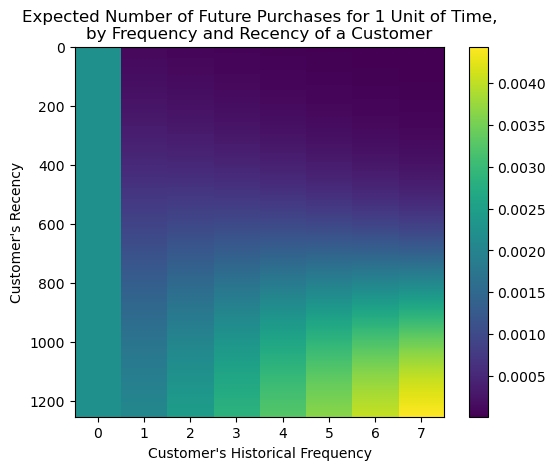

In [14]:
from lifetimes.plotting import plot_frequency_recency_matrix

import matplotlib.pyplot as plt
%matplotlib inline

plot_frequency_recency_matrix(bgf)

Here we can see that our best customers who bought from us at least 2 times and their lastest purchase was when they were around 550 weeks old. The oldest customers which are mainly in the top right corner bought quickly and "disappeard". 

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

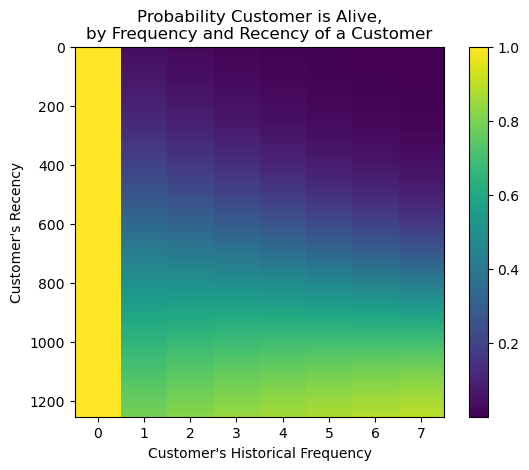

In [19]:
#Let's check the probability of our customers to still being alive
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

So we can see that the customers who have "disappeared" have less probability to be alive.

#### Ranking customers from best to worst

Let's return to our customers and rank them from "highest expected purchases in the next period" to lowest. Models expose a method that will predict a customer's expected purchases in the next period using their history.

In [20]:
t = 1

cltv_pr['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, cltv_pr['frequency'], cltv_pr['recency'], cltv_pr['T']
)

In [21]:
cltv_pr.sort_values(by='predicted_purchases').tail()

recency         T  frequency   monetary  predicted_purchases
customer_id                                                               
891         241.28571 281.57143          3 2034.89000              0.00443
1646        611.28571 660.71429          5 2138.86600              0.00456
1366        678.85714 830.00000          7 1866.64857              0.00457
2591        440.14286 457.00000          4 1982.55250              0.00465
66          125.14286 154.71429          3 1537.08333              0.00485

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

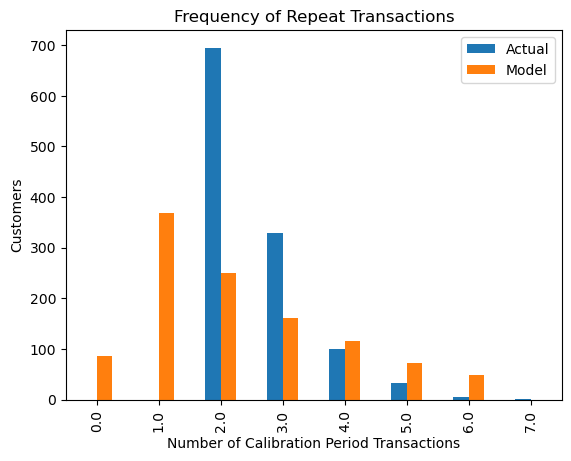

In [22]:
plot_period_transactions(bgf)

## Estimating Customers' Lifetime Value

In [23]:
cltv_pr[['monetary', 'frequency']].corr()

monetary  frequency
monetary    1.00000   -0.00329
frequency  -0.00329    1.00000

We can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [24]:
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(cltv_pr['frequency'],
cltv_pr['monetary'])
print( ggf )

<lifetimes.GammaGammaFitter: fitted with 1162 subjects, p: 3.30, q: 0.22, v: 3.21>


In [25]:
#Average Transaction Value
ggf.conditional_expected_average_profit(
cltv_pr['frequency'],
cltv_pr['monetary']
).head()

customer_id
0   1539.56913
3   1947.09055
4   2669.76060
6   2338.64054
8   1009.86108
dtype: float64

In [26]:
# Setting up the Gamma-Gamma Model

ggf = GammaGammaFitter(penalizer_coef=0.01)  

ggf.fit(cltv_pr['frequency'], cltv_pr['monetary'])


# We are seeing the profit prediction for customers.
cltv_pr["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_pr['frequency'],
                                                                             cltv_pr['monetary'])


cltv_pr.sort_values("expected_average_profit", ascending=False).head(5)

recency         T  frequency   monetary  predicted_purchases  expected_average_profit
customer_id                                                                                        
1278        457.14286 598.71429          2 3928.58000              0.00289               4461.31518
2749        257.71429 375.00000          2 3848.40000              0.00331               4370.29954
2666        103.85714 850.28571          2 3629.34500              0.00053               4121.64115
2108        375.00000 911.57143          2 3588.96500              0.00123               4075.80414
2650         47.42857 477.71429          2 3572.11000              0.00153               4056.67133

In [27]:
# Calculation of CLV prediction using BG-NBD and GG models.

# CLTV Prediction: BG/NBD * Gamma gamma submodel

#Calculating the 3-month CLV prediction.
bgf.fit(cltv_pr['frequency'], cltv_pr['recency'], cltv_pr['T'])
cltv_pred = ggf.customer_lifetime_value(bgf,
                                   cltv_pr['frequency'],
                                   cltv_pr['recency'],
                                   cltv_pr['T'],
                                   cltv_pr['monetary'],
                                   time=3,  
                                   freq="W",  # T and frequency time interval; week(W)
                                   discount_rate=0.01/4) # monthly discount rate ~ 10% annually

cltv_pred = cltv_pred.reset_index()

cltv_pred.head()

customer_id      clv
0            0 64.18897
1            3 24.38711
2            4 78.00913
3            6 34.32972
4            8 28.16000

In [28]:
# Calculation of CLV prediction using BG-NBD and GG models.

# CLTV Prediction: BG/NBD * Gamma gamma submodel

#Calculating the 12-month CLV prediction.
bgf.fit(cltv_pr['frequency'], cltv_pr['recency'], cltv_pr['T'])
cltv_pred = ggf.customer_lifetime_value(bgf,
                                   cltv_pr['frequency'],
                                   cltv_pr['recency'],
                                   cltv_pr['T'],
                                   cltv_pr['monetary'],
                                   time=12,  
                                   freq="W",  # T and frequency time interval; week(W)
                                   discount_rate=0.01) # monthly discount rate ~ 10% annually

cltv_pred = cltv_pred.reset_index()

cltv_pred.head()

customer_id       clv
0            0 238.72261
1            3  90.86695
2            4 290.85376
3            6 128.14167
4            8 104.83997

In [29]:
#Combine CLV predictions with other variables.
cltv_prediction = cltv_pr.merge(cltv_pred, on="customer_id", how="left")

cltv_prediction.head()

customer_id   recency          T  frequency   monetary  predicted_purchases  expected_average_profit       clv
0            0 477.14286  542.28571          2 1354.67500              0.00323               1539.56913 238.72261
1            3 241.28571  841.57143          2 1713.68000              0.00097               1947.09055  90.86695
2            4 563.00000  930.14286          4 2510.03750              0.00226               2669.76060 290.85376
3            6 639.28571 1230.42857          2 2058.61500              0.00114               2338.64054 128.14167
4            8 395.57143  701.28571          2  888.03000              0.00216               1009.86108 104.83997

In [30]:
# Creating Segments Based on CLV

# Dividing the CLV predictions into 4 parts and creating a segment variable.
cltv_prediction["segment"] = pd.qcut(cltv_prediction["clv"], 4, labels=["D", "C", "B", "A"])

cltv_prediction.sort_values(by="clv", ascending=False).head()

customer_id   recency         T  frequency   monetary  predicted_purchases  expected_average_profit       clv segment
1060         2749 257.71429 375.00000          2 3848.40000              0.00331               4370.29954 693.35435       A
153           338 276.42857 292.71429          2 2961.82500              0.00388               3363.91158 625.30341       A
654          1631 364.28571 385.28571          2 3112.98500              0.00366               3535.49955 620.25036       A
516          1278 457.14286 598.71429          2 3928.58000              0.00289               4461.31518 620.23834       A
967          2518 261.28571 283.14286          2 2825.80500              0.00388               3209.50965 596.89285       A

In [31]:
# Creating count, mean, and sum values for all other variables based on the segments.
cltv_prediction.groupby("segment").agg(
    {"count", "mean", "sum"})


# Thus, we can perform operations on customers based on their segments.

customer_id                 recency                            T                    frequency              monetary                    predicted_purchases               expected_average_profit                          clv                  
               mean     sum count      mean          sum count      mean          sum count      mean  sum count       mean          sum count                mean     sum count                    mean          sum count      mean         sum count
segment                                                                                                                                                                                                                                                
D        1422.06529  413821   291 296.35837  86240.28571   291 987.39126 287330.85714   291   2.31959  675   291 1184.65870 344735.68200   291             0.00092 0.26743   291              1330.20155 387088.65062   291  42.64379 12409.34267   291
C        1460.44828  423530   290 514.13793 149100.00000   290 914.66404 265252.57143   290   2.47241  717   290 1327.82716 385069.87517   290             0.00181 0.52583   290              1484.38888 430472.77605   290 112.03427 32489.93865   290
B        1488.61724  431699   290 610.38276 177011.00000   290 863.87438 250523.57143   290   2.63448  764   290 1581.43343 458615.69483   290             0.00244 0.70810   290              1758.63600 510004.44015   290 192.29723 55766.19645   290
A        1528.60825  444825   291 639.64899 186137.85714   291 774.76730 225457.28571   291   2.81787  820   291 2083.57396 606320.02374   291             0.00307 0.89296   291              2304.16640 670512.42125   291 330.59133 96202.07655   291